## Download and unpack a volume from the 3Dircadb1 dataset. 

In [13]:
import os
import zipfile
import requests
import shutil
import tempfile
from tqdm import tqdm
import dicom2nifti

# === CONFIG ===
download_url = "https://cloud.ircad.fr/index.php/s/JN3z7EynBiwYyjy/download?path=%2F3Dircadb1.1"
base_dir = "ircad_dataset"
zip_filename = "3Dircadb1.1.zip"
nifti_output_dir = os.path.join(base_dir, "nifti")
os.makedirs(base_dir, exist_ok=True)
os.makedirs(nifti_output_dir, exist_ok=True)

# === DOWNLOAD ===
zip_path = os.path.join(base_dir, zip_filename)
print("Downloading dataset...")
with requests.get(download_url, stream=True) as r:
    r.raise_for_status()
    total_size = int(r.headers.get('content-length', 0))
    with open(zip_path, 'wb') as f, tqdm(total=total_size, unit='iB', unit_scale=True) as bar:
        for chunk in r.iter_content(chunk_size=1024):
            f.write(chunk)
            bar.update(len(chunk))

# === UNZIP MAIN FILE ===
print("Extracting main zip...")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(base_dir)
os.remove(zip_path)  # Remove the zip file after extraction

# === FUNCTION: Convert DICOM to NIfTI ===
def convert_single_dir_and_copy(dicom_dir, out_dir, data_id):
    with tempfile.TemporaryDirectory() as temp_dir:
        dicom2nifti.convert_directory(dicom_dir, temp_dir, reorient=True)
        for f in os.listdir(temp_dir):
            if f.endswith(".nii.gz"):
                src = os.path.join(temp_dir, f)

                dst = os.path.join(out_dir, f"{data_id.replace('.', '_')}.nii.gz")
                shutil.copy(src, dst)
                print(f"Converted and copied: {dst}")

# === FUNCTION: Unpack Nested Zips and Convert ===
def unpack_and_convert(patient_path, file_name):
    zip_file = os.path.join(patient_path, f"{file_name}.zip")
    if not os.path.isfile(zip_file):
        print(f"File not found: {zip_file}")
        return

    with tempfile.TemporaryDirectory() as temp_dir:
        print(f"Extracting {file_name}.zip...")
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            zip_ref.extractall(temp_dir)

        for root, dirs, _ in os.walk(temp_dir):
            for d in dirs:
                dir_path = os.path.join(root, d)
                if "image_0" in os.listdir(dir_path):
                    convert_single_dir_and_copy(dir_path, nifti_output_dir, os.path.basename(patient_path) + "_" + file_name)

# === PROCESS ALL PATIENT FOLDERS ===
print("Processing extracted patient data...")
for item in os.listdir(base_dir):
    if item.startswith("3Dircadb"):
        patient_dir = os.path.join(base_dir, item)
        unpack_and_convert(patient_dir, "PATIENT_DICOM")
        unpack_and_convert(patient_dir, "LABELLED_DICOM")



40.7MiB [00:09, 4.24MiB/s]


Extracting main zip...
Processing extracted patient data...
Extracting PATIENT_DICOM.zip...
Converted and copied: ircad_dataset/nifti/3Dircadb1_1_PATIENT_DICOM.nii.gz
Extracting LABELLED_DICOM.zip...
Converted and copied: ircad_dataset/nifti/3Dircadb1_1_LABELLED_DICOM.nii.gz


(-0.5, 511.5, 511.5, -0.5)

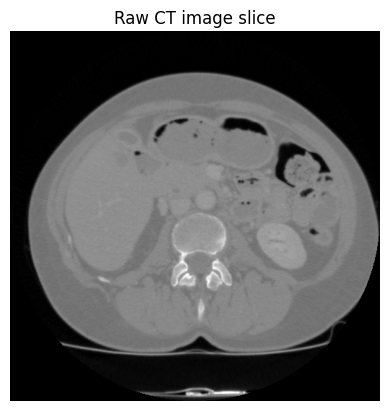

In [37]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np

def reorient_vol(vol, ornt="RAS"):
    # Reorient volume to the specified orientation
    start_ornt = nib.orientations.io_orientation(vol.affine)
    end_ornt = nib.orientations.axcodes2ornt(ornt)
    transform = nib.orientations.ornt_transform(start_ornt, end_ornt)

    vol = vol.as_reoriented(transform)
    return vol

img_path = "ircad_dataset/nifti/3Dircadb1_1_PATIENT_DICOM.nii.gz"
lbl_path = "ircad_dataset/nifti/3Dircadb1_1_LABELLED_DICOM.nii.gz"

# Load the NIfTI images
img = nib.load(img_path)
img = reorient_vol(img, "PLS")

lbl = nib.load(lbl_path)
lbl = reorient_vol(lbl, "PLS")


img_vol = img.get_fdata()
lbl_vol = lbl.get_fdata()

plt.figure()
plt.imshow(img_vol[:, :, 50], cmap="gray")
plt.title("Raw CT image slice")
plt.axis("off")


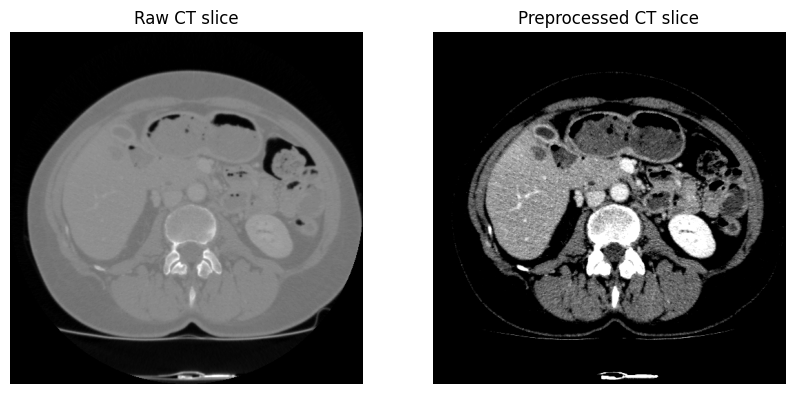

In [56]:
from transforms import RandomWindower

window = [250, 90]  # window width, window level
windower = RandomWindower(p_shift=0, p_scale=0, base_window=window)
random_windower = RandomWindower(p_shift=1.0, p_scale=1.0, base_window=window)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(img_vol[:, :, 50], cmap="gray")
axs[0].set_title("Raw CT slice")
axs[0].axis("off")

axs[1].imshow(windower(img_vol[:, :, 50]), cmap="gray")
axs[1].set_title("Preprocessed CT slice")
axs[1].axis("off")

plt.show()

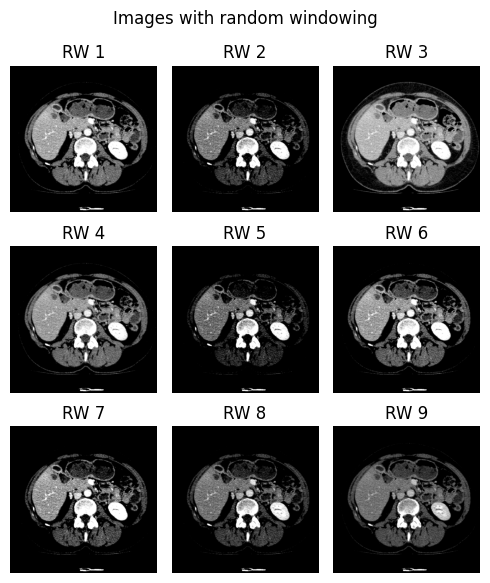

In [69]:
# n x n grid of random windowed images
n_rows = 3
n_cols = 3 
fig, axs = plt.subplots(n_rows, n_cols, figsize=(5, 6))
for i in range(n_rows):
    for j in range(n_cols):
        axs[i, j].imshow(random_windower(img_vol[:, :, 50]), cmap="gray")
        axs[i, j].axis("off")
        axs[i, j].set_title(f"RW {i*n_cols+j+1}")

plt.suptitle("Images with random windowing")
plt.tight_layout()
plt.show()